In [ ]:
import joblib
import numpy as np
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

def get_bootstrap(data1, data2, iterations=1000, sign_level=0.05):
    mean_diff = np.median(data1) - np.median(data2)
    boot_data = []

    # Bootstrap sampling
    for i in range(iterations):
        curr_idxs1 = np.random.choice(len(data1), len(data1))
        curr_idxs2 = np.random.choice(len(data2), len(data2))
        boot_data.append(np.median(data1[curr_idxs1]) - np.median(data2[curr_idxs2]))
    
    boot_data = np.array(boot_data) - mean_diff
    # Calculate p-values
    p_value = sum(np.abs(boot_data) >= np.abs(mean_diff)) / len(boot_data)
    # print(mean_diff, boot_data)
    print(p_value)
    print(p_value < sign_level)
    

block = []
rand = []
prop = []
test = []
prop_equal = []
As = []
Vs = []

with open('get_performance.txt') as f:
    for line in f:
        if line.split(':')[0] == 'BLOCK':
            block.append(float(line.split(':')[2].split(',')[0]) > float(line.split('unstable')[1].split('\n')[0]))
        elif line.split(':')[0] == 'RAND':
            rand.append(float(line.split(':')[2].split(',')[0]) > float(line.split('unstable')[1].split('\n')[0]))
        elif line.split(':')[0] == 'PROP':
            prop.append(float(line.split(':')[2].split(',')[0]) > float(line.split('unstable')[1].split('\n')[0]))
            prop_equal.append(float(line.split(':')[2].split(',')[0]) == float(line.split('unstable')[1].split('\n')[0]))
        elif line.split(':')[0] != 'TEST' and len(line.split(',')) > 1:
            As.append(float(line.split(',')[1].split('A:')[1]))
            Vs.append(float(line.split(',')[2].split('V:')[1]))
   
block_check = []
with open('get_performance_auroc.txt') as f:
    for line in f:
        if line.split(':')[0] == 'BLOCK':
            block_check.append([float(line.split(':')[2].split(',')[0]), float(line.split('unstable')[1].split('\n')[0])])
        elif line.split(':')[0] == 'TEST':
            test.append([float(line.split(':')[2].split(',')[0]), float(line.split('unstable')[1].split('\n')[0])])
  
  

rand_count = 0
block_count = 0
prop_count = 0
dict_ = {}
dict_['Method'] = []
dict_['AUROC'] = []
dict_['A'] = []
dict_['V'] = []

for i in range(len(test)):
    if Vs[i] > 0:
        dict_['Method'].append('$K$-Fold\nRandom CV')
        dict_['AUROC'].append(test[i][rand[i]])
        dict_['A'].append(As[i])
        dict_['V'].append(Vs[i])
        rand_count += 1

        dict_['Method'].append('$K$-Fold\nBlock CV')
        dict_['AUROC'].append(test[i][block[i]])
        dict_['A'].append(As[i])
        dict_['V'].append(Vs[i])
        block_count += 1

        # print(len(dict_['Method']), len(dict_['AUROC']), len(dict_['A']), len(dict_['V']))
        dict_['Method'].append('Proposed\nApproach')
        if prop_equal[i] == 0:
            if block_check[i][prop[i]] < 0.5:
                dict_['AUROC'].append(test[i][abs(1 - prop[i])])
            else:
                dict_['AUROC'].append(test[i][prop[i]])
        else:
            if block_check[i][prop[i]] < block_check[i][abs(1 - prop[i])]:
                dict_['AUROC'].append(test[i][abs(1 - prop[i])])
            else:
                dict_['AUROC'].append(test[i][rand[i]])

        dict_['A'].append(As[i])
        dict_['V'].append(Vs[i])
        prop_count += 1
        # print(len(dict_['Method']), len(dict_['AUROC']), len(dict_['A']), len(dict_['V']))

        # print()



In [ ]:
len(dict_['A'])/3

60.0

In [ ]:
import pandas as pd

df = pd.DataFrame(dict_)
_, old_V_bins = pd.qcut(df['A'], 3, labels=False, retbins=True)
V_bins = ['%0.2f\n$<$A$\leq$\n%0.2f'%(old_V_bins[i], old_V_bins[i+1]) for i in range(len(old_V_bins)-1)]
df['Values of A'] = pd.cut(df['A'], 3, labels=V_bins)
maxA = V_bins[-1]

_, old_V_bins = pd.qcut(df['V'], 3, labels=False, retbins=True)
V_bins = ['%0.3f\n$<$V$\leq$\n%0.3f'%(old_V_bins[i], old_V_bins[i+1]) for i in range(len(old_V_bins)-1)]
df['Values of V'] = pd.cut(df['V'], 3, labels=V_bins)
minV = V_bins[0]

In [ ]:
A_df = df[['Values of A', 'Method', 'AUROC']]
V_df = df[['Values of V', 'Method', 'AUROC']]


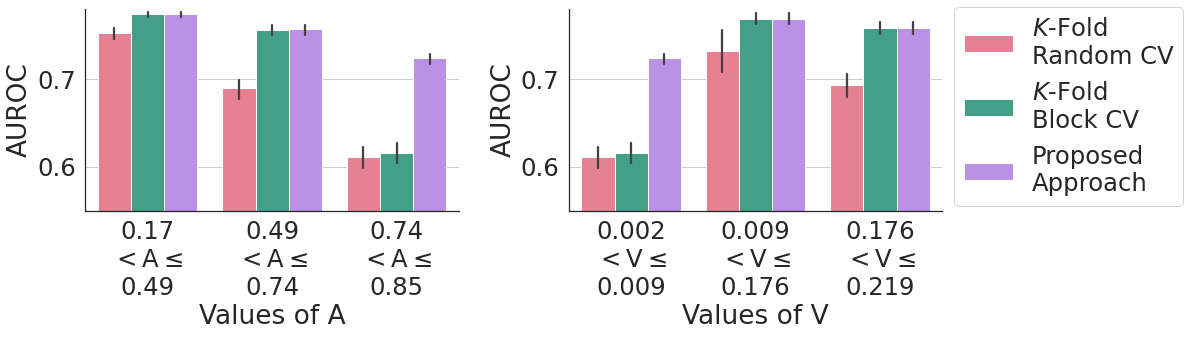

In [9]:
from matplotlib import rc
import matplotlib
import seaborn as sns


fig, axs = plt.subplots(1, 2)
sns.set(font_scale=2.2)
sns.set_style(style='white')

rc = {'figure.figsize':(10,5),
      'axes.facecolor':'white',
      'axes.grid' : True,
      'grid.color': '.8',
      'font.size' : 15}
plt.rcParams.update(rc)


fig.set_figheight(5)
fig.set_figwidth(17)


g = sns.barplot(
    data=A_df, x="Values of A", y="AUROC", hue="Method",
    dodge=True, zorder=1, ax = axs[0], palette=[sns.color_palette("husl", 9)[0], sns.color_palette("husl", 9)[4], sns.color_palette("husl", 9)[7]], legend = False, estimator='median', errorbar=('pi', 50))
# Show the conditional means, aligning each pointplot in the
# center of the strips by adjusting the width allotted to each
# category (.8 by default) by the number of hue levels
axs[0].set_ylim(0.55, 0.78)

sns.barplot(
    data=V_df, x="Values of V", y="AUROC", hue="Method",
    dodge=True, zorder=1, axes = axs[1], palette=[sns.color_palette("husl", 9)[0], sns.color_palette("husl", 9)[4], sns.color_palette("husl", 9)[7]],  legend=True, estimator='median', errorbar=('pi', 50))
# Show the conditional means, aligning each pointplot in the
# center of the strips by adjusting the width allotted to each
# category (.8 by default) by the number of hue levels
axs[1].set_ylim(0.55, 0.78)

# axs[0].plot([-0.3, 2.3], [-np.log(0.5), -np.log(0.5)], linestyle = '--')
# axs[1].plot([-0.3, 2.3], [-np.log(0.5), -np.log(0.5)])
plt.legend(bbox_to_anchor=(1, 1.07))

sns.despine(ax=axs[0])
sns.despine(ax=axs[1])

plt.tight_layout()
plt.savefig('semisynth_auroc.png')

In [ ]:
df_curr = df[df['Values of A'] == maxA]
df_curr = df_curr[df_curr['Values of V'] == minV]

rand = df_curr[df_curr['Method'] == '$K$-Fold\nRandom CV']['AUROC'].quantile([0.25, 0.5,0.75]).round(4)
block = df_curr[df_curr['Method'] == '$K$-Fold\nBlock CV']['AUROC'].quantile([0.25, 0.5,0.75]).round(4)
prop = df_curr[df_curr['Method'] == 'Proposed\nApproach']['AUROC'].quantile([0.25, 0.5,0.75]).round(4)


get_bootstrap(df_curr[df_curr['Method'] == 'Proposed\nApproach']['AUROC'].to_numpy(), df_curr[df_curr['Method'] == '$K$-Fold\nRandom CV']['AUROC'].to_numpy())
get_bootstrap(df_curr[df_curr['Method'] == 'Proposed\nApproach']['AUROC'].to_numpy(), df_curr[df_curr['Method'] == '$K$-Fold\nBlock CV']['AUROC'].to_numpy())

In [ ]:
text1 = '%0.3f, IQR: [%0.3f, %0.3f] vs. '%(prop[0.5], prop[0.25], prop[0.75])
text1 += '%0.3f, 50\%% PI: [%0.3f, %0.3f]) and '%(rand[0.5], rand[0.25], rand[0.75])
text1 += '%0.3f, 50\%% PI: [%0.3f, %0.3f]'%(block[0.5], block[0.25], block[0.75])
print(text1)